## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial kernel
x, c = shortestpath.genData(n+1000, p, grid, deg=deg)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 321.44it/s]


In [8]:
# get training data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 374.04it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression 

In [15]:
import torch
from torch import nn

In [16]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## Training SPO+

In [17]:
from matplotlib import pyplot as plt

In [18]:
from func import SPOPlus

In [19]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [20]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=5e-2)

In [21]:
# init SPO+ loss
criterion = SPOPlus()

In [22]:
# train model
num_epochs = 400
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 10, loss:534.430420
epoch 20, loss:70.406067
epoch 30, loss:46.198250
epoch 40, loss:152.569794
epoch 50, loss:32.356163
epoch 60, loss:27.532219
epoch 70, loss:154.474396
epoch 80, loss:28.524748
epoch 90, loss:27.650135
epoch 100, loss:11.086195
epoch 110, loss:3.499424
epoch 120, loss:9.965139
epoch 130, loss:110.332039
epoch 140, loss:7.537773
epoch 150, loss:9.000134
epoch 160, loss:0.701704
epoch 170, loss:2.768791
epoch 180, loss:16.373608
epoch 190, loss:8.511169
epoch 200, loss:9.372612
epoch 210, loss:27.721537
epoch 220, loss:2.128599
epoch 230, loss:36.586983
epoch 240, loss:9.656429
epoch 250, loss:2.176632
epoch 260, loss:15.577792
epoch 270, loss:0.000023
epoch 280, loss:40.967201
epoch 290, loss:36.964108
epoch 300, loss:1.915237
epoch 310, loss:101.321167
epoch 320, loss:8.840769
epoch 330, loss:3.699295
epoch 340, loss:5.309799
epoch 350, loss:0.000010
epoch 360, loss:12.580271
epoch 370, loss:7.165771
epoch 380, loss:49.167603
epoch 390, loss:32.447983
epoch 40

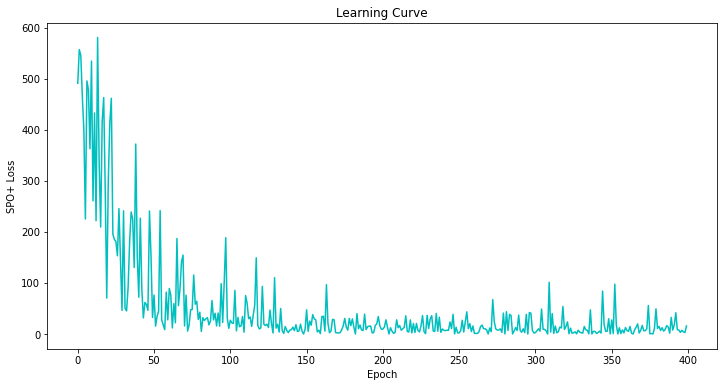

In [23]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [24]:
import numpy as np
from evalm import SPOEval

In [25]:
# evaluate
spoloss = SPOEval(lr, sp_model, sp_loader_test)
print('Normalized SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized SPO Loss: 0.40%


In [26]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -91.91, -5.70, 13.09, 4.66, 92.55, -99.08, -26.04, -1.02, 6.73, 81.49, -10.43, -100.93, -33.53, 33.18, -27.17, 72.24, -86.37, -12.41, 42.14, -22.17, -39.44, -30.33, -0.72, 34.86, 57.47, -73.05, -24.60, 6.68, 33.08, 113.82, 15.38, -16.37, 16.83, -40.38, 29.98, -1.55, -16.38, 2.71, -34.97, 0.19
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.2

##  Training SPO+ with Regularization

In [27]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [28]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=5e-2)

In [29]:
# init SPO+ loss
criterion = SPOPlus()

In [30]:
# train model
num_epochs = 400
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 10, loss:279.437103
epoch 20, loss:190.248032
epoch 30, loss:59.442696
epoch 40, loss:154.577484
epoch 50, loss:65.148697
epoch 60, loss:3.442985
epoch 70, loss:38.146526
epoch 80, loss:74.654160
epoch 90, loss:28.487610
epoch 100, loss:14.986137
epoch 110, loss:8.127003
epoch 120, loss:39.859741
epoch 130, loss:15.946823
epoch 140, loss:62.924927
epoch 150, loss:32.504391
epoch 160, loss:25.155865
epoch 170, loss:12.107728
epoch 180, loss:14.292212
epoch 190, loss:9.203152
epoch 200, loss:18.338886
epoch 210, loss:7.897903
epoch 220, loss:7.588206
epoch 230, loss:61.618851
epoch 240, loss:8.709499
epoch 250, loss:22.255260
epoch 260, loss:32.939617
epoch 270, loss:13.495226
epoch 280, loss:7.224562
epoch 290, loss:91.318085
epoch 300, loss:18.860439
epoch 310, loss:6.462228
epoch 320, loss:13.625124
epoch 330, loss:27.963985
epoch 340, loss:14.911601
epoch 350, loss:15.180235
epoch 360, loss:9.231266
epoch 370, loss:13.999145
epoch 380, loss:4.180523
epoch 390, loss:5.556330
epo

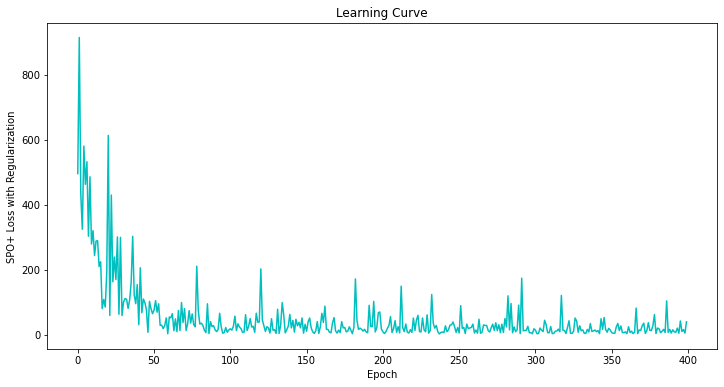

In [31]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [32]:
# evaluate
spoloss = SPOEval(lr, sp_model, sp_loader_test)
print('Normalized SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized SPO Loss: 0.41%


In [33]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -93.50, -6.29, 6.84, -2.81, 93.15, -100.02, -15.75, -14.15, 1.43, 74.83, -16.39, -91.58, -41.13, 30.96, -21.49, 62.50, -89.45, -16.83, 34.25, -23.99, -30.02, -19.22, 1.02, 38.33, 54.22, -73.25, -27.62, 9.27, 42.82, 115.78, 20.87, -19.77, 13.81, -33.18, 33.54, -0.01, -23.79, 2.28, -33.65, 2.33
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.2

## Training Black-Box

In [34]:
from func import blackboxOpt

In [35]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [36]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=1e-4)

In [37]:
# set loss
criterion = nn.L1Loss()

In [38]:
# train model
num_epochs = 400
lambd = 10
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = lr(x)
        # black-box optimizer
        wp = blackboxOpt.apply(sp_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 10, loss:245.381348
epoch 20, loss:172.526184
epoch 30, loss:273.199493
epoch 40, loss:150.983856
epoch 50, loss:162.467468
epoch 60, loss:197.031265
epoch 70, loss:80.345337
epoch 80, loss:93.984299
epoch 90, loss:51.814880
epoch 100, loss:60.728546
epoch 110, loss:15.760502
epoch 120, loss:42.720463
epoch 130, loss:43.755836
epoch 140, loss:23.250042
epoch 150, loss:42.186279
epoch 160, loss:59.337891
epoch 170, loss:4.022812
epoch 180, loss:4.364738
epoch 190, loss:10.295364
epoch 200, loss:18.317738
epoch 210, loss:45.426830
epoch 220, loss:19.344147
epoch 230, loss:26.181728
epoch 240, loss:77.267685
epoch 250, loss:33.125641
epoch 260, loss:17.924625
epoch 270, loss:4.733377
epoch 280, loss:95.868217
epoch 290, loss:23.102875
epoch 300, loss:39.502457
epoch 310, loss:22.896980
epoch 320, loss:61.612011
epoch 330, loss:15.639635
epoch 340, loss:25.538113
epoch 350, loss:48.823002
epoch 360, loss:17.233967
epoch 370, loss:56.601681
epoch 380, loss:34.183105
epoch 390, loss:4.

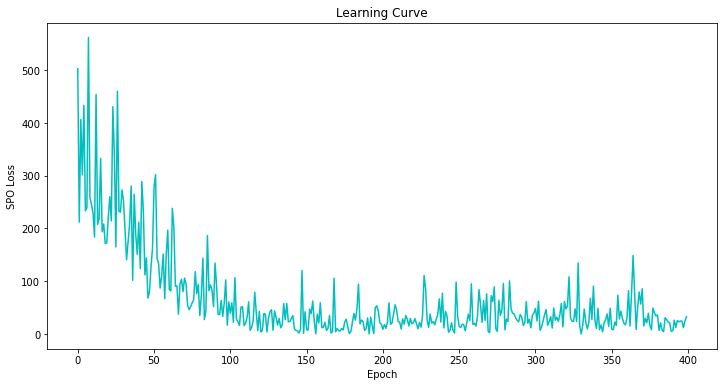

In [39]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [40]:
# evaluate
spoloss = SPOEval(lr, sp_model, sp_loader_test)
print('Normalized SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized SPO Loss: 11.02%


In [41]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -1.01, -1.01, -0.13, 0.60, -0.48, 0.23, 0.43, -0.03, -1.23, -0.30, -0.81, -0.59, -0.27, -0.70, -0.90, -0.70, -0.49, -0.09, -0.50, -0.62, -0.37, -0.19, -1.68, -1.37, 0.19, 0.11, 0.67, -0.19, 0.93, -0.45, 0.37, -0.52, -0.39, -0.96, -0.47, 0.21, -0.06, 0.55, 0.03, 1.05
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 220.04

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 2.75, 6.06, 8.38, 55.24,

## Training Black-Box with Regularization

In [42]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [43]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=1e-4)

In [44]:
# set loss
criterion = nn.L1Loss()

In [45]:
# train model
num_epochs = 400
lambd = 10
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = lr(x)
        # black-box optimizer
        wp = blackboxOpt.apply(sp_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 10, loss:326.676514
epoch 20, loss:259.937073
epoch 30, loss:217.679825
epoch 40, loss:137.775406
epoch 50, loss:280.597473
epoch 60, loss:87.364006
epoch 70, loss:171.562958
epoch 80, loss:38.255920
epoch 90, loss:23.904076
epoch 100, loss:54.246685
epoch 110, loss:20.234461
epoch 120, loss:19.451220
epoch 130, loss:42.855934
epoch 140, loss:7.288713
epoch 150, loss:26.748264
epoch 160, loss:15.681385
epoch 170, loss:51.005714
epoch 180, loss:170.897949
epoch 190, loss:19.013876
epoch 200, loss:34.158611
epoch 210, loss:42.939148
epoch 220, loss:102.267960
epoch 230, loss:33.697983
epoch 240, loss:79.583023
epoch 250, loss:13.637678
epoch 260, loss:34.194675
epoch 270, loss:17.267986
epoch 280, loss:16.729126
epoch 290, loss:59.320160
epoch 300, loss:59.854324
epoch 310, loss:59.194691
epoch 320, loss:97.402611
epoch 330, loss:14.108549
epoch 340, loss:36.555264
epoch 350, loss:22.007103
epoch 360, loss:48.929989
epoch 370, loss:84.687874
epoch 380, loss:62.871201
epoch 390, los

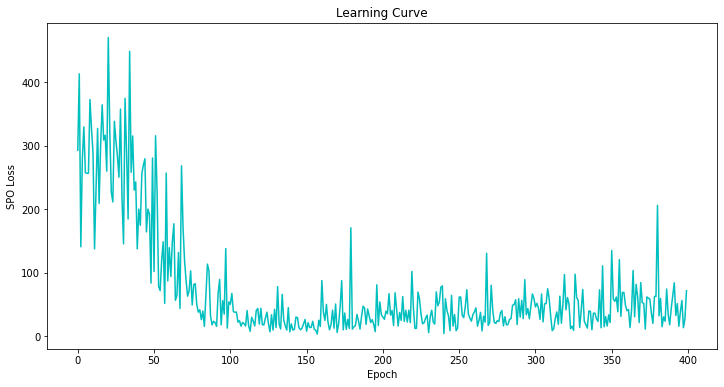

In [46]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [47]:
# evaluate
spoloss = SPOEval(lr, sp_model, sp_loader_test)
print('Normalized SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized SPO Loss: 9.94%


In [48]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: 0.30, 0.06, 0.60, -1.28, -0.17, 0.72, 0.52, -0.02, 0.31, 1.19, -0.14, -0.37, -0.53, 0.06, -0.58, -0.36, 0.59, 1.16, 0.54, 0.08, 0.57, 0.04, 0.40, -0.66, -0.14, -0.17, 0.33, -0.51, 0.60, 0.54, 0.54, -0.37, -0.01, 0.05, -0.60, 0.13, -0.06, 0.71, -0.10, 1.27
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 227.97

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 2.75, 6.06, 8.38, 55.24, 7.29, 55.2